(0.0, 5.1)

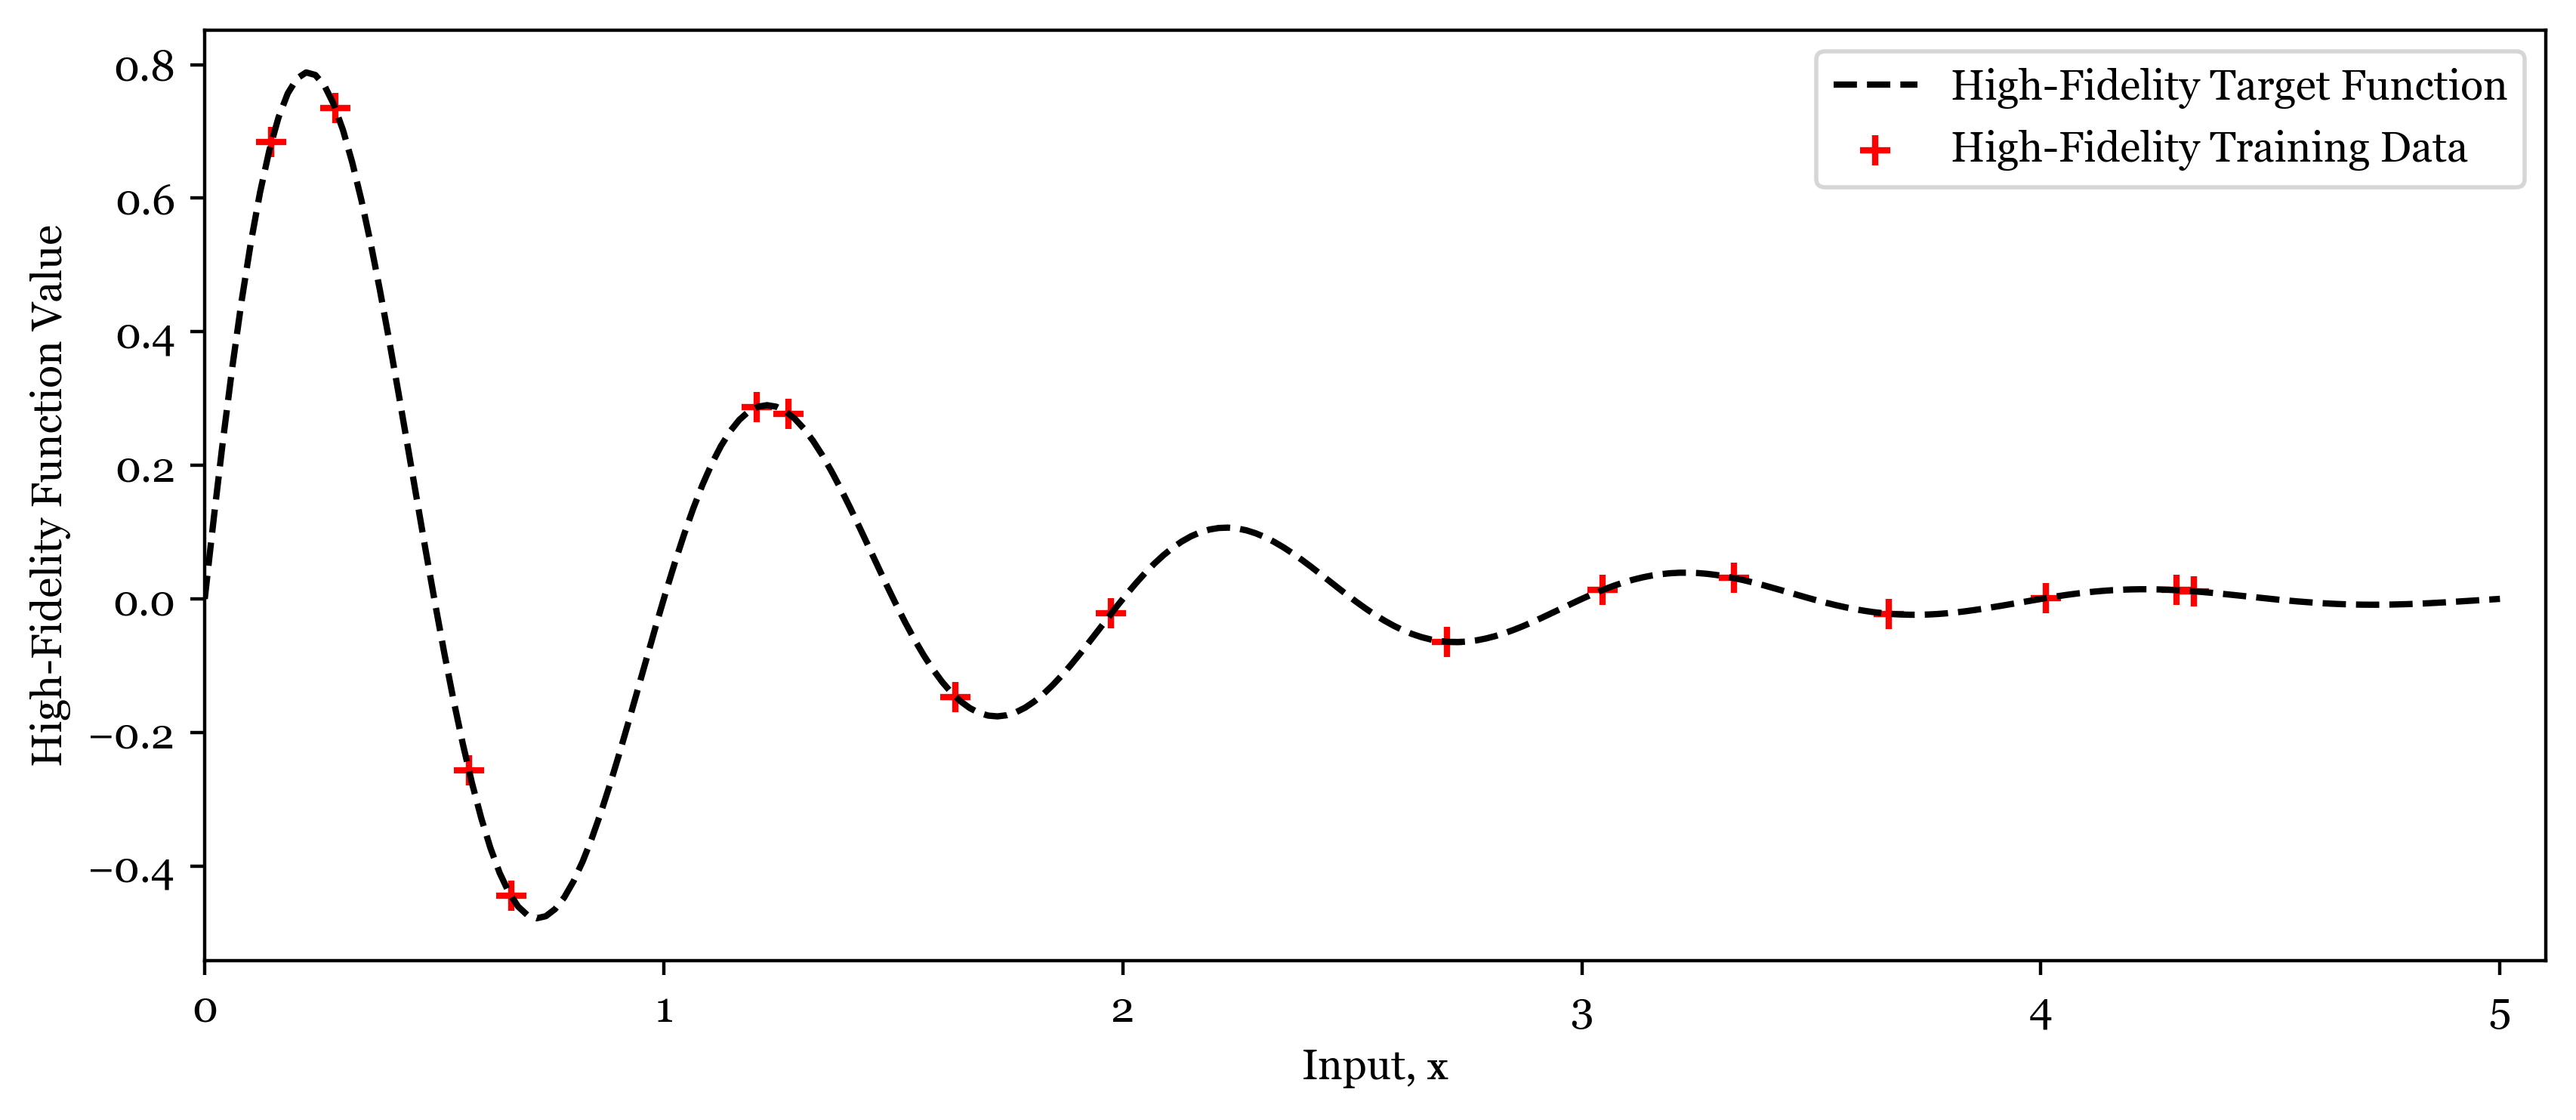

In [1]:
import sys
sys.path.append("..")   # add parent folder (project/) to Python path
from gplib.mf import *   # now absolute import worksimport math 
import matplotlib.pyplot as plt 

# Plot parameters 
plt.rcParams.update({
    "font.family": "georgia",
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'mathtext.fontset': 'cm',
})

# Define number of fidelity-levels 
n_fidelities = 3 

# Define a list of sample sizes
sample_sizes = [15, 100, 250]

# Define the high and low-fidelity functions
funcs = [
    lambda x: np.exp(-x) * np.sin(2*math.pi*x), 
    lambda x: np.sin(2*math.pi*x),
    lambda x: np.exp(-x)
]

# Making some testing data 
Xtest = np.linspace(0.0, 5.0, 250).reshape(-1,1)

# Loading high-fidelity data
true_data = np.hstack((Xtest, funcs[0](Xtest)))

# Selecting optimal high-fidelity data
np.random.seed(43)
cutoff = 0.0
X_hf = np.random.uniform(cutoff, 5.0, size = sample_sizes[0]).reshape(-1,1)
hf_data = np.hstack((X_hf, funcs[0](X_hf)))

# Loading medium-fidelity data 
X_mf = np.random.uniform(0.0, 5.0, size = sample_sizes[1]).reshape(-1,1)
mf_data = np.hstack((X_mf, funcs[1](X_mf)))

# Loading low-fidelity data 
X_lf = np.random.uniform(0.0, 5.0, size = sample_sizes[2]).reshape(-1,1)
lf_data = np.hstack((X_lf, funcs[2](X_lf)))

# Creating a multi-fidelity-friendly data dictionary 
data_dict = {
    2:{
        'X':hf_data[:,0].reshape(-1,1),
        'Y':hf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(hf_data[:,1]),
        'cost':100.0
    },
    1:{
        'X':mf_data[:,0].reshape(-1,1),
        'Y':mf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(mf_data[:,1]),
        'cost':2.0
    },
    0:{
        'X':lf_data[:,0].reshape(-1,1),
        'Y':lf_data[:,1],
        'noise_var':1e-6,
        'var':np.var(lf_data[:,1]),
        'cost':1.0
    }
}


plt.figure(figsize=(10,4),dpi = 400)
plt.plot(Xtest.ravel(), funcs[0](Xtest).ravel(), linestyle = 'dashed', color = 'black', label = 'High-Fidelity Target Function')
plt.scatter(hf_data[:,0], hf_data[:,1], s = 50, marker = '+', color = 'red', label = 'High-Fidelity Training Data')

plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("High-Fidelity Function Value")
plt.legend()
plt.xlim([0,5.1])

In [2]:
model = Hyperkriging(
    data_dict, RBF, Linear, max_cond = 1e5, epsilon = 1e-12
)

Calibrated white noise variance: 2.3225e-05
Calibrated white noise variance: 1.2913e-04
Calibrated white noise variance: 1.0000e-06


In [ ]:
model.optimize(0, params = ['k_param', 'm_param'], lr = 1e-2, epochs = 1000, beta = 0.95)

Best Objective Value: -1.0542e+03


100%|██████████| 1000/1000 [00:15<00:00, 65.59it/s, Loss: -1.0593e+03]


In [ ]:
model.optimize(1, params = ['k_param', 'm_param', 'noise_var'], lr = 1e-4, epochs = 1000, beta = 0.95)

Best Objective Value: -2.2209e+02


100%|██████████| 1000/1000 [00:14<00:00, 69.17it/s, Loss: -9.4151e+02]


In [8]:
model.optimize(2, params = ['k_param', 'm_param', 'noise_var'], lr = 2e-2, epochs = 2500, beta = 0.95)

Best Objective Value: -1.3526e+01


100%|██████████| 2500/2500 [00:44<00:00, 56.63it/s, Loss: -3.0587e+01]


In [11]:
# model.d[2]['model'].p['noise_var'] = jnp.array(-1e5)
mu, cov = model.predict(Xtest, 2, full_cov = False)
cov = jnp.sqrt(cov)*1.96

(0.0, 5.1)

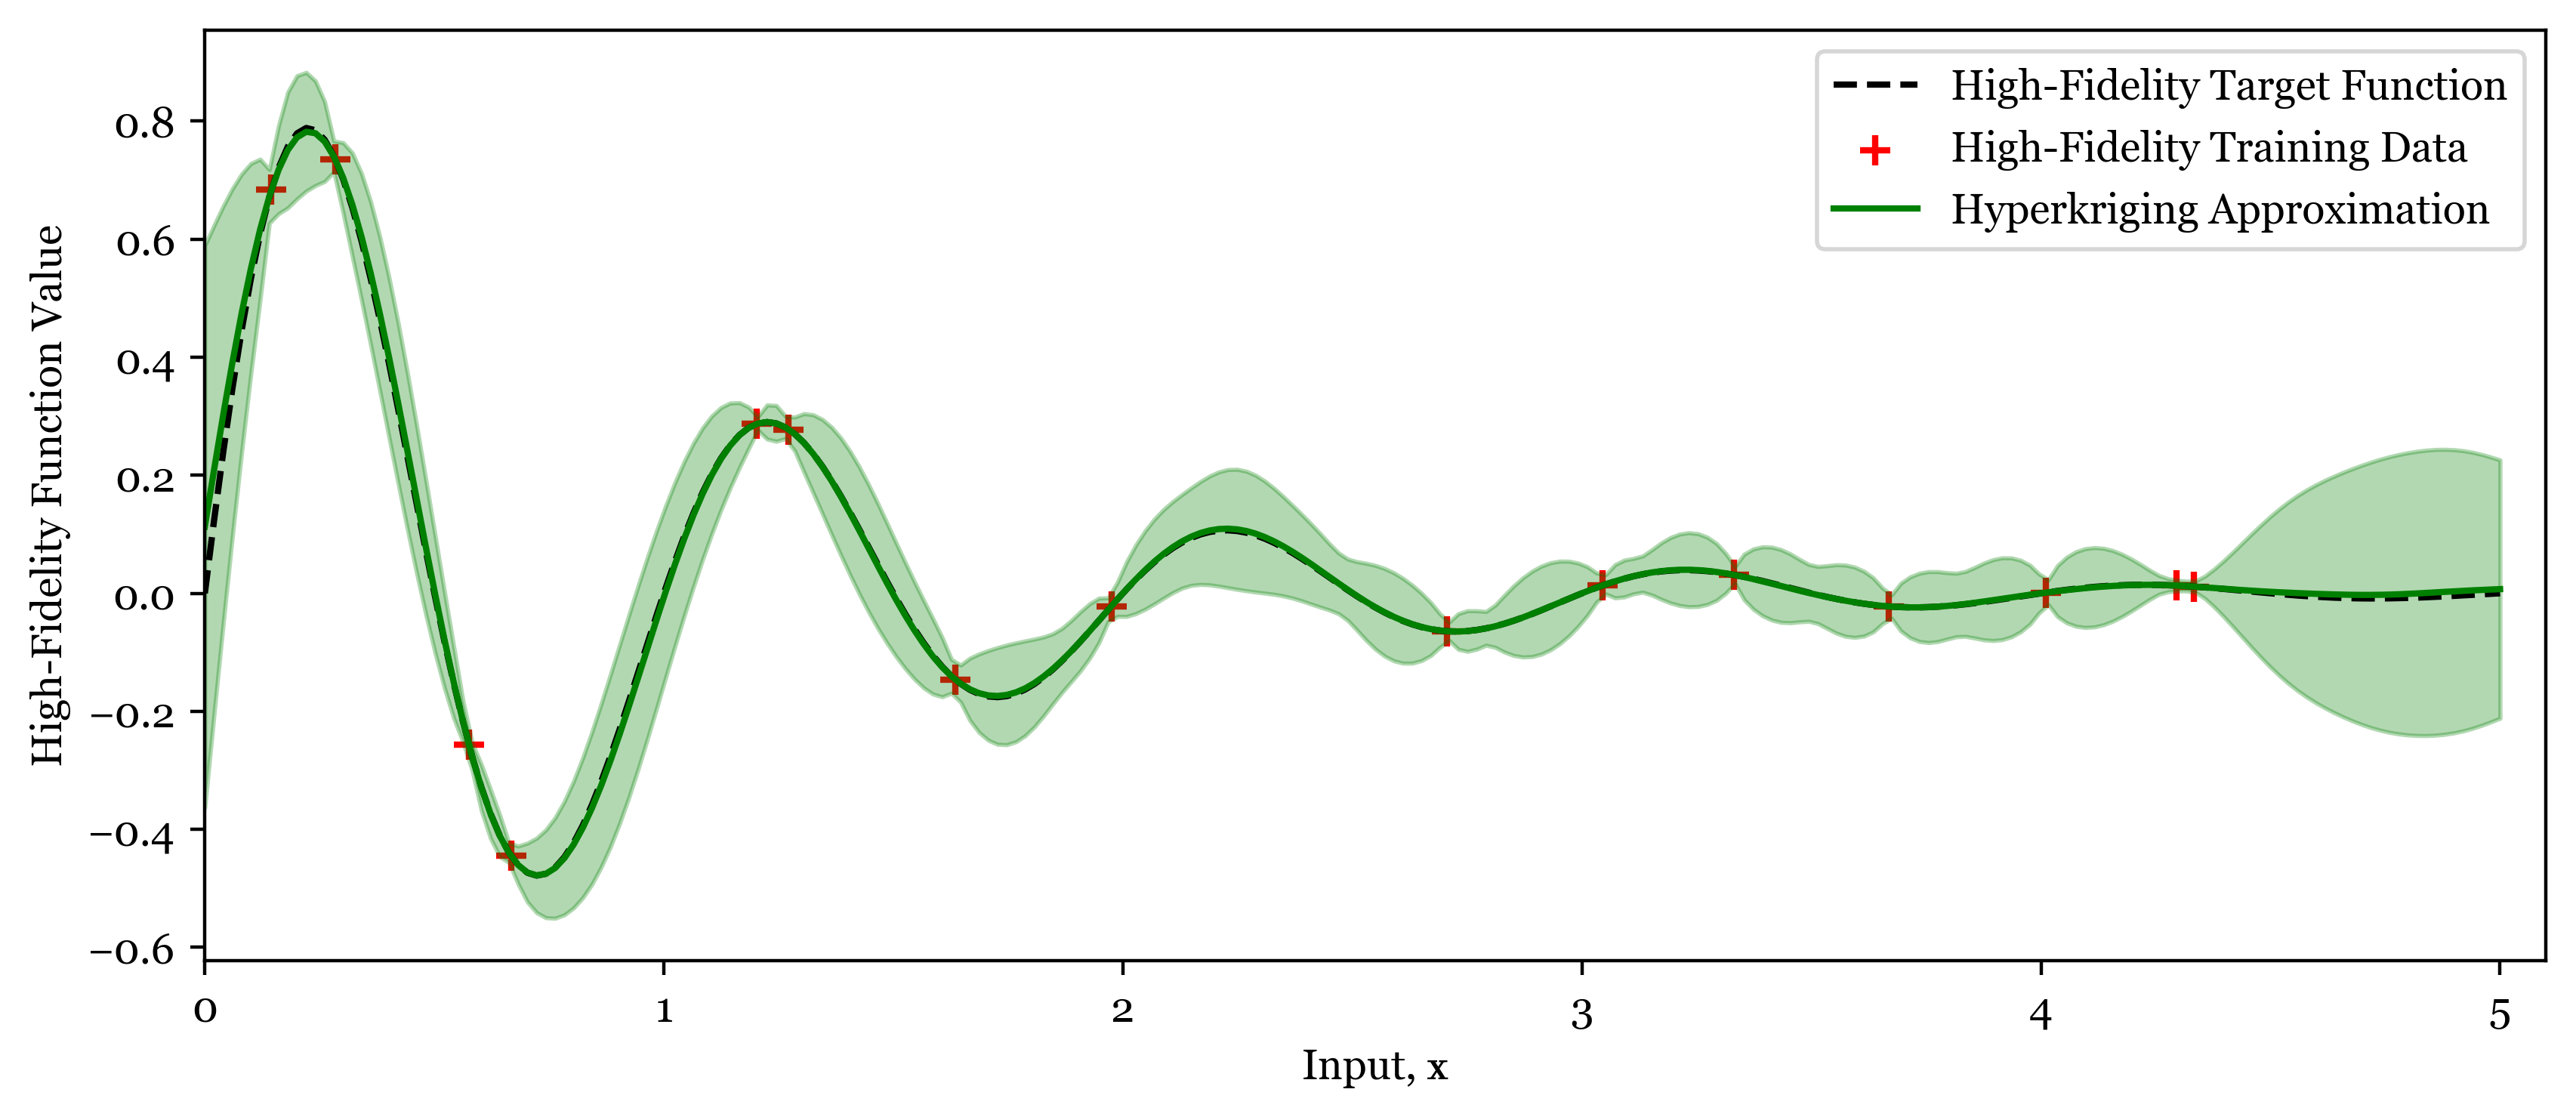

In [12]:
plt.figure(figsize=(10,4),dpi = 400)
plt.plot(Xtest.ravel(), funcs[0](Xtest).ravel(), linestyle = 'dashed', color = 'black', label = 'High-Fidelity Target Function')
plt.scatter(hf_data[:,0], hf_data[:,1], s = 50, marker = '+', color = 'red', label = 'High-Fidelity Training Data')
plt.plot(Xtest.ravel(), mu, color = 'green', label = "Hyperkriging Approximation")
plt.fill_between(Xtest.ravel(), mu -2*np.sqrt(cov), mu + 2*np.sqrt(cov), alpha = 0.3, color = 'green')

plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("High-Fidelity Function Value")
plt.legend()
plt.xlim([0,5.1])